# Chapter 6

## Question 8

Running best subset selection on simulated data

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd 
import itertools
import sklearn.linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt

sns.set(style="whitegrid")

### (a) Generate a predictor X of length n=100, as well as a noise vector $\epsilon$ of length n=100

In [2]:
x = np.random.normal(size=100)
eps = np.random.normal(size=100)


### (b) Generate a response vector Y according to the model ... (see below)

In [3]:
# Constants of your choice
b0 = 1
b1 = 2
b2 = 3
b3 = 4
y = b0 + b1*x + b2*np.square(x) + b3*np.power(x,3) + eps 

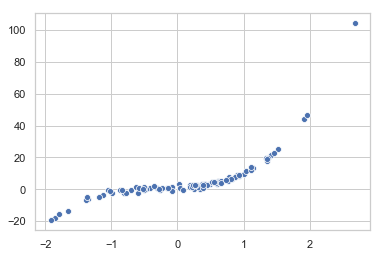

In [4]:
sns.scatterplot(x,y)

### (c) Perform best subset selection (they use `regsubsets()` in r) to choose the best model containing the predictors X, X^2, .... X^10. What is the best model according to $C_p$, BIC, and adjusted R? Show some plots to justify this, and report the coefficients of the best model.

In [5]:
# Create a data frame with X, X^2, X^3 ... X^10, and Y.

predictors = np.vstack([x, *(np.power(x,i) for i in range(2,11))]).T

df = pd.DataFrame(data=predictors, columns="x x2 x3 x4 x5 x6 x7 x8 x9 x10".split())
df["y"] = y
df.head()


,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.185714,0.034490,0.006405,0.001190,0.000221,0.000041,0.000008,0.000001,2.627915e-07,4.880417e-08,3.013694
1,0.779396,0.607458,0.473450,0.369005,0.287601,0.224155,0.174705,0.136164,1.061260e-01,8.271414e-02,7.553538
2,-1.356519,1.840145,-2.496192,3.386132,-4.593354,6.230973,-8.452435,11.465892,-1.555370e+01,2.109890e+01,-6.262695
3,1.013529,1.027241,1.041139,1.055224,1.069500,1.083969,1.098634,1.113498,1.128562e+00,1.143831e+00,9.448852
4,0.372392,0.138676,0.051642,0.019231,0.007161,0.002667,0.000993,0.000370,1.377221e-04,5.128663e-05,3.220310


I have to implement best subset selection manually.


For k=1,2,...,n

- Fit all $n\choose{k}$ models with k predictors
- Pick the best among these, call it $M_k$. Define the best as having e.g. the smallest RSS (or highest $R^2$).
- Select the single best model from $M_0$ (the null model), $M_1$, $M_2$ etc, using cross-validated test error, $C_p$, BIC etc


In [6]:
# I have to implement best subset selection manually.
def get_linear_reg_score(X,Y):
    """Given X and Y, fit a linear model and return the R^2 score"""
    model = sklearn.linear_model.LinearRegression()
    model.fit(X,Y)
    Rsquared = model.score(X,Y)
    return Rsquared


bestPredictors = []

x_df = df.drop(columns=["y"])

p = len(x_df.columns)
for k in range(1,p+1):
    print(k)
    bestModelRss = 0
    bestColumns = None
    for subset in itertools.combinations(x_df.columns,k):
        rss = get_linear_reg_score(x_df[list(subset)],y)
        if rss > bestModelRss:
            bestModelRss = rss
            bestColumns = list(subset) 
    bestPredictors.append(bestColumns)

1
2
3
4
5
6
7
8
9
10


In [7]:
print(bestPredictors)

[['x3'], ['x2', 'x3'], ['x', 'x2', 'x3'], ['x', 'x2', 'x3', 'x4'], ['x', 'x2', 'x3', 'x4', 'x9'], ['x', 'x2', 'x3', 'x6', 'x8', 'x10'], ['x', 'x2', 'x3', 'x4', 'x6', 'x8', 'x10'], ['x', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9', 'x10'], ['x', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'], ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']]


In [8]:
# Select the best of these models, using C_p, AIC, BIC, or adjusted R^2
# Lets get all the above and plot them vs k.

# I'll switch to statsmodels for this

AICs = []
BICs = []
adjustedR2s = []
for i, cols in enumerate(bestPredictors):
    k = i+1
    model = sm.OLS(y, sm.add_constant(x_df[cols]))
    results = model.fit()
    AICs.append(results.aic)
    BICs.append(results.bic)
    adjustedR2s.append(results.rsquared_adj)

/home/will/.local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


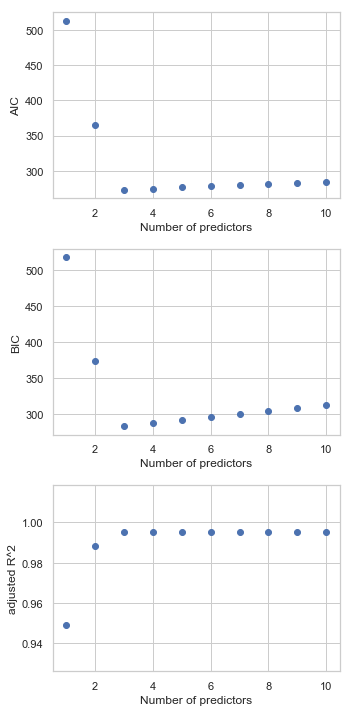

In [9]:
fig, axes = plt.subplots(nrows=3, figsize=(5,10))

scores = {"AIC":AICs, "BIC":BICs, "adjusted R^2":adjustedR2s}

for ax, score in zip(axes, scores.items()):
    score_name, score_data = score
    ax.scatter(range(1,11), score_data)
    ax.set_ylabel(score_name)
    ax.set_xlabel("Number of predictors")
plt.tight_layout()

Looks like the data supports 3 predictors (i.e. X, X^2, X^3) as expected

In [10]:
overallBestPredictors = bestPredictors[2]
overallBestPredictors

['x', 'x2', 'x3']

In [12]:
model = sklearn.linear_model.LinearRegression()
model.fit(x_df[overallBestPredictors],y)
print(f"predicted coefficients: {model.intercept_},", ", ".join(map(str, model.coef_)))
print(f"actual coefficients: {b0}, {b1}, {b2}, {b3}")


predicted coefficients: 0.9943592450141274, 2.1536881147207123, 3.037112797845064, 3.9505118025050177
actual coefficients: 1, 2, 3, 4
